In [1]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.8MB/s eta 0:00:01
     |████████████████████████████████| 47.9MB 22.5MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/ad/fd/6bfe87920d7f4fd475acd28500a42482b6b84479832bdc0fe9e589a60ceb/Keras-2.3.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl


In [1]:
import tensorflow as tf
from os import listdir
from numpy import asarray
from numpy import savez_compressed
from PIL import Image
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplotb

Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.1.0


### Use Multi-Task Cascaded Convolutional Neural Network (MTCNN) to detect faces in dataset

In [3]:
# load an image as an rgb numpy array
def load_image(filename):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    return pixels

# extract the face from a loaded image and resize
def extract_face(model, pixels, required_size=(128, 128)):
    # detect face in the image
    faces = model.detect_faces(pixels)
    # skip cases where we could not detect a face
    if len(faces) == 0:
        return None
    # extract details of the face
    x1, y1, width, height = faces[0]['box']
    # force detected pixel values to be positive (bug fix)
    x1, y1 = abs(x1), abs(y1)
    # convert into coordinates
    x2, y2 = x1 + width, y1 + height
    # retrieve face pixels
    face_pixels = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face_pixels)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array
 
# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
    # prepare model
    model = MTCNN()
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # load the image
        pixels = load_image(directory + filename)
        # get face
        face = extract_face(model, pixels)
        if face is None:
            continue
        # store
        faces.append(face)
#         print(len(faces), face.shape)
        # stop once we have enough
        if len(faces) >= n_faces:
            break
    return asarray(faces)
 
# directory that contains all images
directory = 'img_align_celeba/'
# load and extract all faces
all_faces = load_faces(directory, 50000)
print('Loaded: ', all_faces.shape)
# save in compressed format
savez_compressed('img_align_celeba_128.npz', all_faces)

Loaded:  (50000, 128, 128, 3)


In [4]:
from numpy import load

# load the face dataset
data = load('img_align_celeba_128.npz')
faces = data['arr_0']
print('Loaded: ', faces.shape)

Loaded:  (50000, 128, 128, 3)


Loaded:  (50000, 128, 128, 3)


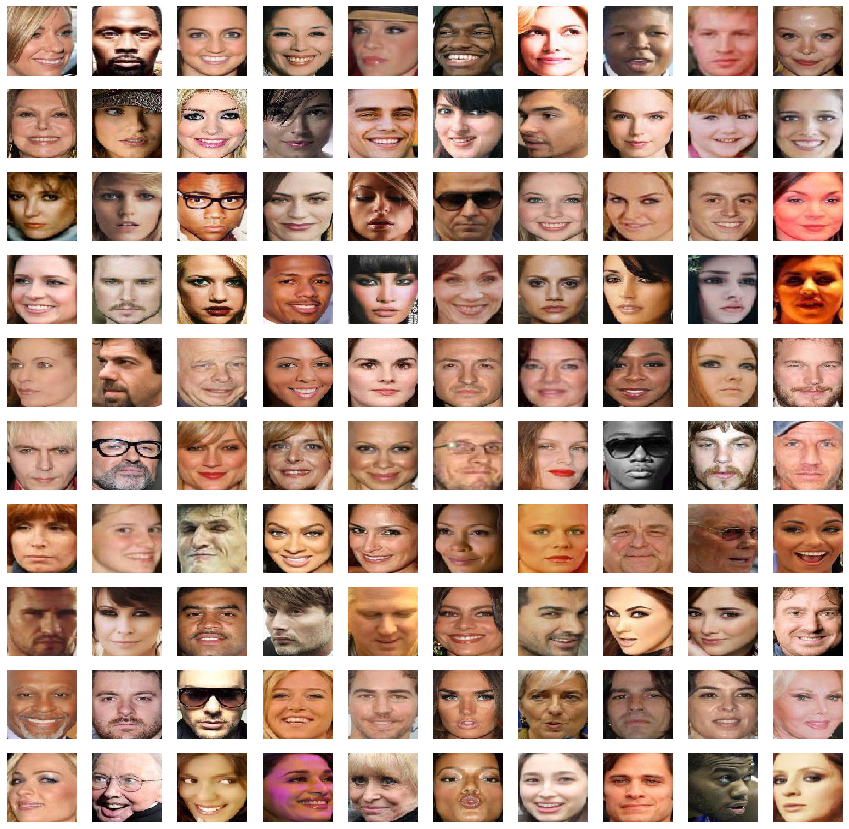

In [5]:
%matplotlib inline
pyplot.rcParams['figure.figsize'] = (15, 15)

def plot_faces(faces, n):
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(faces[i].astype('uint8'))
    pyplot.show()

print('Loaded: ', faces.shape)
plot_faces(faces, 10)

In [ ]:
# example of progressive growing gan on celebrity faces dataset
from math import sqrt
from numpy import load
from numpy import asarray
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from skimage.transform import resize
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import AveragePooling2D
from keras.layers import LeakyReLU
from keras.layers import Layer
from keras.layers import Add
from keras.constraints import max_norm
from keras.initializers import RandomNormal
from keras import backend
from matplotlib import pyplot


class PixelNormalization(Layer):

    def __init__(self, **kwargs):
        super(PixelNormalization, self).__init__(**kwargs)


    def call(self, inputs):
        values = inputs**2.0
        mean_values = backend.mean(values, axis=-1, keepdims=True)
        mean_values += 1.0e-8
        l2 = backend.sqrt(mean_values)
        normalized = inputs / l2

        return normalized

    def compute_output_shape(self, input_shape):
        return input_shape


class MinibatchStdev(Layer):

    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)


    def call(self, inputs):
        mean = backend.mean(inputs, axis=0, keepdims=True)
        squ_diffs = backend.square(inputs - mean)
        mean_sq_diff = backend.mean(squ_diffs, axis=0, keepdims=True)
        mean_sq_diff += 1e-8
        stdev = backend.sqrt(mean_sq_diff)
        mean_pix = backend.mean(stdev, keepdims=True)
        shape = backend.shape(inputs)
        output = backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))

        combined = backend.concatenate([inputs, output], axis=-1)

        return combined

    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        input_shape[-1] += 1

        return tuple(input_shape)


class WeightedSum(Add):

    def __init__(self, alpha=0.0, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)
        self.alpha = backend.variable(alpha, name='ws_alpha')


    def _merge_function(self, inputs):
        assert (len(inputs) == 2)
        output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])

        return output

    
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)


def add_discriminator_block(old_model, n_input_layers=3):
    init = RandomNormal(stddev=0.02)
    const = max_norm(1.0)
    in_shape = list(old_model.input.shape)
    # print('in_shape: {}'.format(in_shape[-2].value))

    input_shape = (in_shape[-2]*2, in_shape[-2]*2, in_shape[-1])
    in_image = Input(shape=input_shape)

    d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = AveragePooling2D()(d)
    block_new = d

    for i in range(n_input_layers, len(old_model.layers)):
        d = old_model.layers[i](d)

    model1 = Model(in_image, d)

    model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))

    downsample = AveragePooling2D()(in_image)

    block_old = old_model.layers[1](downsample)
    block_old = old_model.layers[2](block_old)

    d = WeightedSum()([block_old, block_new])

    for i in range(n_input_layers, len(old_model.layers)):
        d = old_model.layers[i](d)

    model2 = Model(in_image, d)

    model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))

    return [model1, model2]


def define_discriminator(n_blocks, input_shape=(4,4,3)):
    init = RandomNormal(stddev=0.02)
    const = max_norm(1.0)
    model_list = list()
    in_image = Input(shape=input_shape)

    d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
    d = LeakyReLU(alpha=0.2)(d)

    d = MinibatchStdev()(d)
    d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(128, (4,4), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Flatten()(d)
    out_class = Dense(1)(d)

    model = Model(in_image, out_class)

    model.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))

    model_list.append([model, model])

    for i in range(1, n_blocks):
        old_model = model_list[i - 1][0]
        models = add_discriminator_block(old_model)
        model_list.append(models)

    return model_list


def add_generator_block(old_model):
    init = RandomNormal(stddev=0.02)
    const = max_norm(1.0)
    block_end = old_model.layers[-2].output
    upsampling = UpSampling2D()(block_end)
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(upsampling)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)

    out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(g)

    model1 = Model(old_model.input, out_image)

    out_old = old_model.layers[-1]
    out_image2 = out_old(upsampling)

    merged = WeightedSum()([out_image2, out_image])
    model2 = Model(old_model.input, merged)

    return [model1, model2]


def define_generator(latent_dim, n_blocks, in_dim=4):
    init = RandomNormal(stddev=0.02)

    const = max_norm(1.0)
    model_list = list()

    in_latent = Input(shape=(latent_dim,))

    g  = Dense(128 * in_dim * in_dim, kernel_initializer=init, kernel_constraint=const)(in_latent)
    g = Reshape((in_dim, in_dim, 128))(g)

    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)

    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)

    out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(g)

    model = Model(in_latent, out_image)
    model_list.append([model, model])

    for i in range(1, n_blocks):
        old_model = model_list[i - 1][0]
        models = add_generator_block(old_model)
        model_list.append(models)

    return model_list


def define_composite(discriminators, generators):
    model_list = list()

    for i in range(len(discriminators)):
        g_models, d_models = generators[i], discriminators[i]
        d_models[0].trainable = False
        model1 = Sequential()
        model1.add(g_models[0])
        model1.add(d_models[0])
        model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))

        d_models[1].trainable = False
        model2 = Sequential()
        model2.add(g_models[1])
        model2.add(d_models[1])
        model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
        model_list.append([model1, model2])

    return model_list

# load dataset
def load_real_samples(filename):
    data = load(filename)
    X = data['arr_0']
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5

    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))

    return X, y


def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)

    return x_input


def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = -ones((n_samples, 1))

    return X, y


def update_fadein(models, step, n_steps):
    alpha = step / float(n_steps - 1)
    for model in models:
        for layer in model.layers:
            if isinstance(layer, WeightedSum):
                backend.set_value(layer.alpha, alpha)


def train_epochs(g_model, d_model, gan_model, dataset, n_epochs, n_batch, fadein=False):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs

    half_batch = int(n_batch / 2)

    for i in range(n_steps):
        if fadein:
            update_fadein([g_model, d_model, gan_model], i, n_steps)

        X_real, y_real = generate_real_samples(dataset, half_batch)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

        d_loss1 = d_model.train_on_batch(X_real, y_real)
        d_loss2 = d_model.train_on_batch(X_fake, y_fake)

        z_input = generate_latent_points(latent_dim, n_batch)
        y_real2 = ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(z_input, y_real2)
        # summarize loss on this batch
#         print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))

# scale images to preferred size
def scale_dataset(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

# generate samples and save as a plot and save the model
def summarize_performance(status, g_model, latent_dim, n_samples=25):
    # devise name
    gen_shape = g_model.output_shape
    name = '%03dx%03d-%s' % (gen_shape[1], gen_shape[2], status)
    # generate images
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # normalize pixel values to the range [0,1]
    X = (X - X.min()) / (X.max() - X.min())
    # plot real images
    square = int(sqrt(n_samples))
    for i in range(n_samples):
        pyplot.subplot(square, square, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i])
    # save plot to file
    filename1 = 'plot_%s.png' % (name)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%s.h5' % (name)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_models, d_models, gan_models, dataset, latent_dim, e_norm, e_fadein, n_batch):
    # fit the baseline model
    g_normal, d_normal, gan_normal = g_models[0][0], d_models[0][0], gan_models[0][0]
    # scale dataset to appropriate size
    gen_shape = g_normal.output_shape
    scaled_data = scale_dataset(dataset, gen_shape[1:])
    print('Scaled Data', scaled_data.shape)
    # train normal or straight-through models
    train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[0], n_batch[0])
    summarize_performance('tuned', g_normal, latent_dim)
    # process each level of growth
    for i in range(1, len(g_models)):
        # retrieve models for this level of growth
        [g_normal, g_fadein] = g_models[i]
        [d_normal, d_fadein] = d_models[i]
        [gan_normal, gan_fadein] = gan_models[i]
        # scale dataset to appropriate size
        gen_shape = g_normal.output_shape
        scaled_data = scale_dataset(dataset, gen_shape[1:])
        print('Scaled Data', scaled_data.shape)
        # train fade-in models for next level of growth
        train_epochs(g_fadein, d_fadein, gan_fadein, scaled_data, e_fadein[i], n_batch[i], True)
        summarize_performance('faded', g_fadein, latent_dim)
        # train normal or straight-through models
        train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[i], n_batch[i])
        summarize_performance('tuned', g_normal, latent_dim)

# number of growth phases, e.g. 6 == [4, 8, 16, 32, 64, 128]
n_blocks = 6
# size of the latent space
latent_dim = 100
# define models
d_models = define_discriminator(n_blocks)
print('d_models defined...')
# define models
g_models = define_generator(latent_dim, n_blocks)
print('g_models defined...')
# define composite models
gan_models = define_composite(d_models, g_models)
print('gan_models defined...')
# load image data
dataset = load_real_samples('img_align_celeba_128.npz')
print('Loaded', dataset.shape)
# train model
n_batch = [16, 16, 16, 8, 4, 4]
# 10 epochs == 500K images per training phase
n_epochs = [5, 8, 8, 10, 10, 10]
train(g_models, d_models, gan_models, dataset, latent_dim, n_epochs, n_epochs, n_batch)

tracking <tf.Variable 'ws_alpha:0' shape=() dtype=float32, numpy=0.0> alpha
tracking <tf.Variable 'ws_alpha:0' shape=() dtype=float32, numpy=0.0> alpha
tracking <tf.Variable 'ws_alpha:0' shape=() dtype=float32, numpy=0.0> alpha
tracking <tf.Variable 'ws_alpha:0' shape=() dtype=float32, numpy=0.0> alpha
tracking <tf.Variable 'ws_alpha:0' shape=() dtype=float32, numpy=0.0> alpha
d_models defined...
tracking <tf.Variable 'ws_alpha:0' shape=() dtype=float32, numpy=0.0> alpha
tracking <tf.Variable 'ws_alpha:0' shape=() dtype=float32, numpy=0.0> alpha
tracking <tf.Variable 'ws_alpha:0' shape=() dtype=float32, numpy=0.0> alpha
tracking <tf.Variable 'ws_alpha:0' shape=() dtype=float32, numpy=0.0> alpha
tracking <tf.Variable 'ws_alpha:0' shape=() dtype=float32, numpy=0.0> alpha
g_models defined...
gan_models defined...
Loaded (50000, 128, 128, 3)
Scaled Data (50000, 4, 4, 3)


/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>Saved: plot_004x004-tuned.png and model_004x004-tuned.h5
Scaled Data (50000, 8, 8, 3)


/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>Saved: plot_008x008-faded.png and model_008x008-faded.h5


/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>Saved: plot_008x008-tuned.png and model_008x008-tuned.h5
Scaled Data (50000, 16, 16, 3)


/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>Saved: plot_016x016-faded.png and model_016x016-faded.h5


/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>Saved: plot_016x016-tuned.png and model_016x016-tuned.h5
Scaled Data (50000, 32, 32, 3)


/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>Saved: plot_032x032-faded.png and model_032x032-faded.h5


/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>Saved: plot_032x032-tuned.png and model_032x032-tuned.h5
Scaled Data (50000, 64, 64, 3)


/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/hunter/packages/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
